In [1]:
import os
import itertools
import shutil
import random

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.layers import Dense, Activation,Reshape, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.models import load_model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
random.seed(10)
np.random.seed(10)
tf.random.set_seed(10)

In [3]:
train_path = r"C:\Users\Administrator\Desktop\Folder\image_folder\class_images\split\train"
valid_path =  r"C:\Users\Administrator\Desktop\Folder\image_folder\class_images\split\val"
test_path =  r"C:\Users\Administrator\Desktop\Folder\image_folder\class_images\split\test"

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=32)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=32)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=32, shuffle=False)

Found 8342 images belonging to 33 classes.
Found 1030 images belonging to 33 classes.
Found 1074 images belonging to 33 classes.


In [5]:
temp_model=keras.applications.Xception()
temp_model.summary()
print(len(temp_model.layers))

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

In [6]:
base_model=keras.applications.Xception(input_shape=(224,224,3), weights='imagenet', include_top=False)
#Training only the last 6 layers. 
#Freezing the first 132-6=126 layers 
for layer in base_model.layers[:126]:
    layer.trainable = False
    
base_model.summary()
print(len(base_model.layers))


Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 28, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 28, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 14, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 14, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_19 (Add)                   (None, 14, 14, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_18[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 14, 728)  0          ['add_19[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 14, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 14, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 14, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 14, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_22 (A

In [7]:
for layer in base_model.layers:
    print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000028F72CC4E50> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000028F0EF07430> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000028F0F36CEE0> False
<keras.layers.core.activation.Activation object at 0x0000028F0F39DA60> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000028F0F525040> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000028F0F4C5730> False
<keras.layers.core.activation.Activation object at 0x0000028F0F4D11F0> False
<keras.layers.convolutional.separable_conv2d.SeparableConv2D object at 0x0000028F0F525130> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000028F0C053700> False
<keras.layers.core.activation.Activation object at 0x0000028F0F57BCA0> False
<keras.layers.convolutional.separable_conv2d.SeparableConv2D object at 0x0000028F0F583220> False
<keras.layers.normalization.batch_nor

In [14]:
# Adding a custom fully connected layers on top of the pre-trained base
x=base_model.output
x = GlobalAveragePooling2D()(base_model.output) 
x = keras.layers.BatchNormalization()(x)
x = Dropout(0.5)(x)
#x = Dense(2048, activation='relu', kernel_regularizer=l2(0.01))(x)
#x = Dense(512, activation='relu')(x)   # Another fully connected layer
preds=Dense(33,activation='softmax')(x) #final layer with softmax activation


model=Model(inputs=base_model.input,outputs=preds)
model.summary()
print(len(model.layers))


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

 block4_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 28, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 28, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 14, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 14, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_19 (Add)                   (None, 14, 14, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_18[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 14, 728)  0          ['add_19[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 14, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 14, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 14, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 14, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_22 (A

In [15]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=15,
            verbose=2
)

Epoch 1/15
261/261 - 981s - loss: 0.7657 - accuracy: 0.7994 - val_loss: 1.0106 - val_accuracy: 0.9049 - 981s/epoch - 4s/step
Epoch 2/15
261/261 - 1048s - loss: 0.1291 - accuracy: 0.9626 - val_loss: 0.2891 - val_accuracy: 0.9165 - 1048s/epoch - 4s/step
Epoch 3/15
261/261 - 1786s - loss: 0.0629 - accuracy: 0.9835 - val_loss: 0.2944 - val_accuracy: 0.9233 - 1786s/epoch - 7s/step
Epoch 4/15
261/261 - 1726s - loss: 0.0366 - accuracy: 0.9915 - val_loss: 0.3120 - val_accuracy: 0.9223 - 1726s/epoch - 7s/step
Epoch 5/15
261/261 - 1673s - loss: 0.0231 - accuracy: 0.9957 - val_loss: 0.3041 - val_accuracy: 0.9301 - 1673s/epoch - 6s/step
Epoch 6/15
261/261 - 1693s - loss: 0.0213 - accuracy: 0.9941 - val_loss: 0.3218 - val_accuracy: 0.9214 - 1693s/epoch - 6s/step
Epoch 7/15
261/261 - 1762s - loss: 0.0161 - accuracy: 0.9968 - val_loss: 0.3744 - val_accuracy: 0.9204 - 1762s/epoch - 7s/step
Epoch 8/15
261/261 - 1733s - loss: 0.0110 - accuracy: 0.9978 - val_loss: 0.2914 - val_accuracy: 0.9282 - 1733s/ep

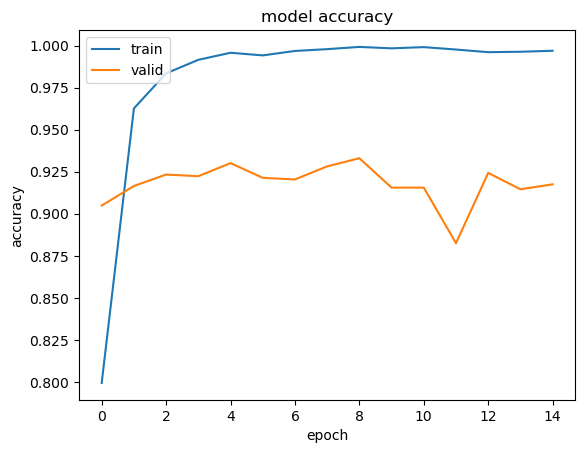

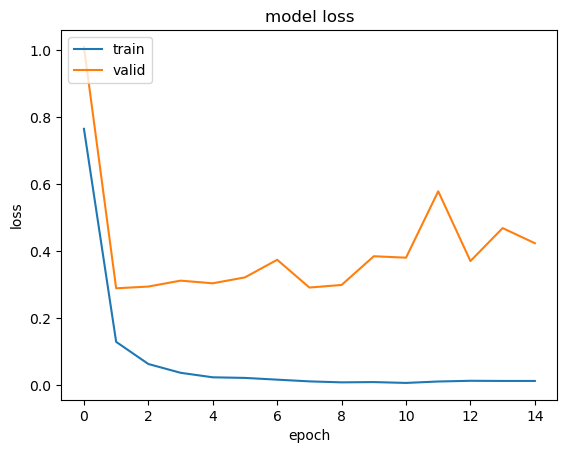

In [16]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [17]:
test_labels = test_batches.classes
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [18]:
y_pred_bool = np.argmax(predictions, axis=1)

print(classification_report(test_labels, y_pred_bool))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.93      0.91      0.92        44
           2       0.67      0.40      0.50        10
           3       0.91      0.94      0.92        62
           4       0.81      0.91      0.86        33
           5       0.90      1.00      0.95        18
           6       0.96      0.92      0.94        53
           7       1.00      0.98      0.99        43
           8       0.92      0.80      0.85        59
           9       0.79      0.89      0.84        56
          10       1.00      0.90      0.95        10
          11       0.97      0.97      0.97        32
          12       0.99      0.98      0.99       122
          13       0.90      0.95      0.92        19
          14       1.00      1.00      1.00        20
          15       0.98      1.00      0.99        55
          16       0.41      0.64      0.50        11
          17       0.94    

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 8  0  0 ...  0  0  0]
 [ 0 40  0 ...  0  0  1]
 [ 0  0  4 ...  0  0  0]
 ...
 [ 0  1  0 ... 10  0  1]
 [ 0  0  0 ...  0 16  0]
 [ 0  0  0 ...  0  0 55]]


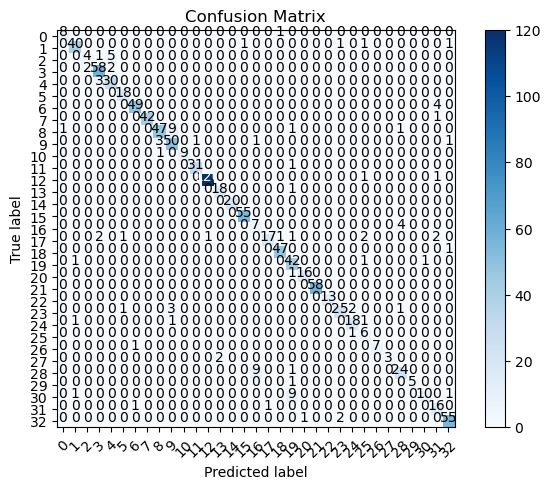

In [20]:
test_batches.class_indices

cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [21]:
test_labels

array([ 0,  0,  0, ..., 32, 32, 32])

In [22]:
from alibi.explainers import IntegratedGradients

In [23]:
tf. __version__

'2.10.0'

In [24]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.applications.xception import preprocess_input

#load the image
my_image = load_img( r'C:\Users\Administrator\Desktop\Folder\image_folder\class_images\split\test\1\9954.png', target_size=(224, 224))


my_image = img_to_array(my_image)
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
my_image = preprocess_input(my_image)

X = my_image

In [25]:
predictions = model.predict(X).argmax(axis=1)
ig = IntegratedGradients(model=model)
explanation = ig.explain(X, target=predictions) #predictions
print(predictions)

1/1 [==============================] - 5s 5s/step
[1]


In [26]:
# Get attributions values from the explanation object
attrs = explanation.attributions[0]

In [27]:
from alibi.utils import visualize_image_attr

In [32]:
squeezedX = np.squeeze(X)

data = np.array(squeezedX).astype('uint8')

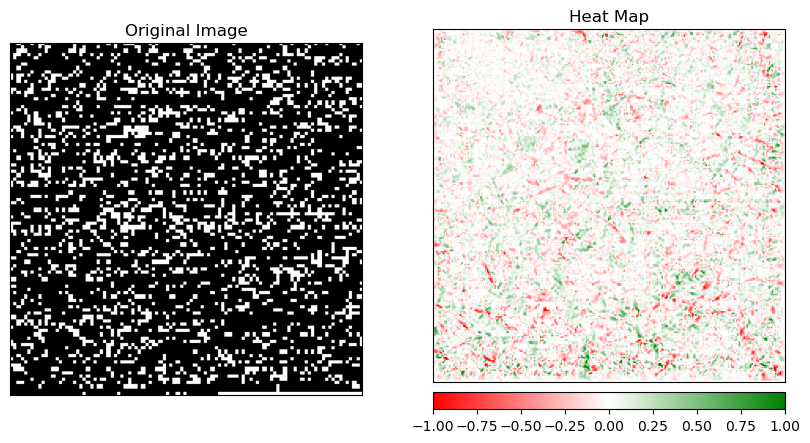

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
visualize_image_attr(attr=None, original_image=data, method='original_image',
                    title='Original Image', plt_fig_axis=(fig, ax[0]), use_pyplot=False);

visualize_image_attr(attr=attrs.squeeze(), original_image=data, method='heat_map',
                    sign='all', show_colorbar=True, title='Heat Map',
                     plt_fig_axis=(fig, ax[1]), use_pyplot=True);

In [34]:
print(predictions)

[1]
